In [1]:
#Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Models
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Useful Libraries 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#Evaluation 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_curve, auc


In [2]:
df = pd.read_csv(r'C:\Users\victo\Desktop\kaggle\bank_churn\BankChurners.csv')

In [3]:
df.drop(columns = ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                          'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                  'CLIENTNUM'],inplace=True)

In [4]:
for i in df.columns:
    print(i)

Attrition_Flag
Customer_Age
Gender
Dependent_count
Education_Level
Marital_Status
Income_Category
Card_Category
Months_on_book
Total_Relationship_Count
Months_Inactive_12_mon
Contacts_Count_12_mon
Credit_Limit
Total_Revolving_Bal
Avg_Open_To_Buy
Total_Amt_Chng_Q4_Q1
Total_Trans_Amt
Total_Trans_Ct
Total_Ct_Chng_Q4_Q1
Avg_Utilization_Ratio


## Feature Engineering

In [5]:
churn_map = {"Existing Customer": 0, "Attrited Customer":1}
df.replace({"Attrition_Flag": churn_map},inplace=True)
df.rename(columns = {'Attrition_Flag': 'y'},inplace=True)

In [6]:
cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
df= pd.get_dummies(df, columns = cols)
df.drop(columns = ['Income_Category_Unknown','Marital_Status_Unknown','Education_Level_Unknown','Gender_F'],inplace=True)

In [7]:
churn_map = {"Existing Customer": 0, "Attrited Customer":1}
df.replace({"Attrition_Flag": churn_map},inplace=True)
df.rename(columns = {'Attrition_Flag': 'y'},inplace=True)

In [8]:
y = df['y']
X = df.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


## SMOTE

In [9]:
#best practice should've put it in a pipeline in sklearn 
SM = SMOTE(random_state=714)
x_SM, y_SM = SM.fit_resample(x_train, y_train)
scoring = {'AUC': 'roc_auc','precision':'precision','f1':'f1'} 

In [10]:
x_SM, x_sm_test, y_SM, y_sm_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [15]:
x_SM.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
2856,36,0,24,4,3,2,2570.0,2230,340.0,0.686,...,0,0,0,0,0,1,1,0,0,0
6515,44,3,36,5,2,3,25276.0,0,25276.0,0.849,...,1,0,0,1,0,0,0,0,0,1
7141,46,2,30,6,3,1,11670.0,915,10755.0,0.892,...,0,0,0,0,1,0,1,0,0,0
632,36,2,24,3,1,3,3124.0,1593,1531.0,0.869,...,0,0,0,0,0,1,1,0,0,0
3496,50,1,40,4,2,3,34516.0,1185,33331.0,0.725,...,1,1,0,0,0,0,1,0,0,0


## Models

In [16]:
#BASELINE smoteless clfer
rf_params_no_sm = { 'class_weight':'balanced'}
rf_no_sm_clfer = RandomForestClassifier(**rf_params_no_sm)

In [17]:
#should've integrated pipeline with sklearn
scaler = MinMaxScaler()

x_train_log = scaler.fit_transform(x_SM)

x_test_log = scaler.transform(x_test)

In [19]:
xgb_params= {'booster': 'gbtree', 'lambda': 0.8510980791355207,
             'alpha': 5.887029350317066e-08, 'subsample': 0.6131070998395973, 
             'colsample_bytree': 0.6900176269350642, 'learning_rate': 0.04334524528572498, 
             'max_depth': 8, 'gamma': 4.2724632731185067e-07, 'min_child_weight': 0.18379329253685098}

lgb_params = {'objective': 'binary', 'metric': 'binary_logloss',
              'verbosity': -1, 'boosting_type': 'gbdt',
              'device_type': 'gpu', 'feature_pre_filter': False, 
              'num_leaves': 28, 'feature_fraction': 0.5, 'bagging_fraction': 0.768023517992883, 
              'bagging_freq': 5, 'min_child_samples': 20}

rf_params = {'criterion': 'gini', 'n_estimators': 1130, 'max_depth': 3, 'max_features': 'sqrt'}

xgb_sm_clfer =  xgb.XGBClassifier(**xgb_params)
lgb_sm_clfer = lgb.LGBMClassifier(**lgb_params)
log_clfer = LogisticRegression(solver='liblinear', random_state=0)

In [20]:
xgb_sm_clfer.fit(x_SM, y_SM, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(x_sm_test, y_sm_test)])

lgb_sm_clfer.fit(x_SM, y_SM,eval_set=[(x_sm_test, y_sm_test)],early_stopping_rounds=50,eval_metric=['auc'])
rf_no_sm_clfer.fit(x_train,y_train)
log_clfer.fit(x_SM,y_SM)

[0]	validation_0-auc:0.95284
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.95908
[2]	validation_0-auc:0.96671
[3]	validation_0-auc:0.96606
[4]	validation_0-auc:0.97162
[5]	validation_0-auc:0.97369
[6]	validation_0-auc:0.97183
[7]	validation_0-auc:0.97794
[8]	validation_0-auc:0.97697
[9]	validation_0-auc:0.97987
[10]	validation_0-auc:0.97969
[11]	validation_0-auc:0.98040
[12]	validation_0-auc:0.97949
[13]	validation_0-auc:0.97935
[14]	validation_0-auc:0.98082
[15]	validation_0-auc:0.98065
[16]	validation_0-auc:0.97988
[17]	validation_0-auc:0.97875
[18]	validation_0-auc:0.98176
[19]	validation_0-auc:0.98284
[20]	validation_0-auc:0.98377
[21]	validation_0-auc:0.98424
[22]	validation_0-auc:0.98458
[23]	validation_0-auc:0.98498
[24]	validation_0-auc:0.98511
[25]	validation_0-auc:0.98507
[26]	validation_0-auc:0.98525
[27]	validation_0-auc:0.98564
[28]	validation_0-auc:0.98537
[29]	validation_0-auc:0.98517
[30]	validation_0-auc:0.98558
[31]	validation_

LogisticRegression(random_state=0, solver='liblinear')

In [21]:
best_xgb_iter = xgb_sm_clfer.get_booster().best_ntree_limit

In [22]:
xgb_preds = xgb_sm_clfer.predict_proba(x_test,ntree_limit=best_xgb_iter)[:, 1]
lgb_preds = lgb_sm_clfer.predict_proba(x_test)[:, 1]
rf_no_sm_preds = rf_no_sm_clfer.predict_proba(x_test)[:, 1]
log_preds = log_clfer.predict_proba(x_test_log)[:, 1]


In [23]:
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, xgb_preds)
lgb_fpr, lgb_tpr, lgb_threshold = roc_curve(y_test, lgb_preds)
rf_no_sm_fpr, rf_no_sm_tpr, rf_no_sm_threshold = roc_curve(y_test, rf_no_sm_preds)
log_fpr, log_tpr, lgb_threshold = roc_curve(y_test, log_preds)


In [24]:
xgb_auc = roc_auc_score(y_test, xgb_preds)
lgb_auc = roc_auc_score(y_test, xgb_preds)
rf_no_sm_auc = roc_auc_score(y_test, rf_no_sm_preds)
log_auc = roc_auc_score(y_test, log_preds)


In [25]:
print(lgb_auc)
print(xgb_auc)
print(rf_no_sm_auc)
print(log_auc)


0.991301044634378
0.991301044634378
0.9836268258490481
0.6770370370370371


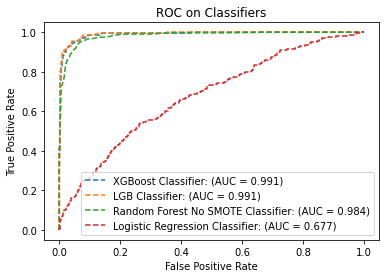

In [26]:
plt.title('ROC on Classifiers')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(xgb_fpr,xgb_tpr,linestyle='--', label = 'XGBoost Classifier: (AUC = %.3f)'%  xgb_auc)
plt.plot(lgb_fpr,lgb_tpr,linestyle='--', label = 'LGB Classifier: (AUC = %.3f)'%  lgb_auc)
plt.plot(rf_no_sm_fpr,rf_no_sm_tpr,linestyle='--', label = 'Random Forest No SMOTE Classifier: (AUC = %.3f)'%  rf_no_sm_auc)
plt.plot(log_fpr,log_tpr,linestyle='--', label = 'Logistic Regression Classifier: (AUC = %.3f)'%  log_auc)

plt.legend()


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

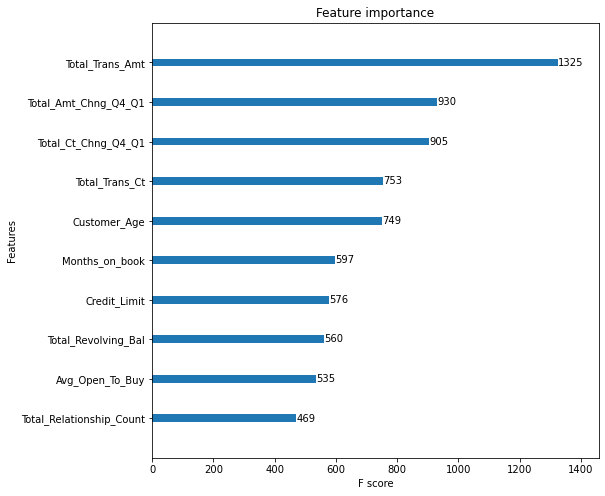

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
xgb.plot_importance(xgb_sm_clfer, max_num_features=10, ax=ax,grid=False)

In [28]:
clfers = {'XGB SMOTE': xgb_sm_clfer, 'Random Forest w/o SMOTE' : rf_no_sm_clfer, 'LGB SMOTE': xgb_sm_clfer,
         'Logistic Classifier': log_clfer}

def show_metrics(clfs,x_test, y_test):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]

    for key, val in clfs.items():
        print(key)
        y_pred = val.predict(x_test)
        sns.heatmap((confusion_matrix(y_pred,y_test)),annot= True,cmap='Blues',fmt='g',cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel('True')
        plt.show()
        print(f'{classification_report(y_pred,y_test)}')

In [29]:
def df_scores(clfs,x_test, y_test):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    precision = []
    recall = []
    f1 = []
    index = []
    df= pd.DataFrame()
    for key, val in clfs.items():
        index.append(key)
        y_pred = val.predict(x_test)
        f1_ = f1_score(y_pred,y_test)
        f1.append(f1_)  
        
        precision_ = precision_score(y_pred,y_test)
        precision.append(precision_) 
        
        recall_ = recall_score(y_pred,y_test)
        recall.append(recall_) 
    df['F1'] = f1
    df['Precision'] = precision
    df['Recall'] = recall
    df['Models'] = index
    df.set_index('Models',inplace=True)
    return df
df_scores = df_scores(clfers,x_test,y_test)    

XGB SMOTE


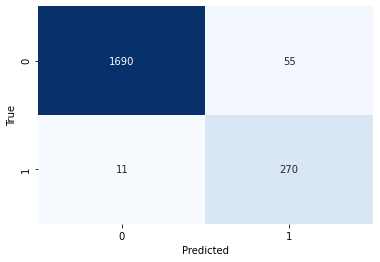

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1745
           1       0.83      0.96      0.89       281

    accuracy                           0.97      2026
   macro avg       0.91      0.96      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Random Forest w/o SMOTE


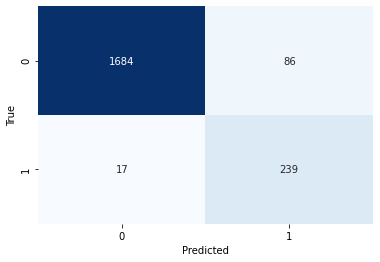

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1770
           1       0.74      0.93      0.82       256

    accuracy                           0.95      2026
   macro avg       0.86      0.94      0.90      2026
weighted avg       0.96      0.95      0.95      2026

LGB SMOTE


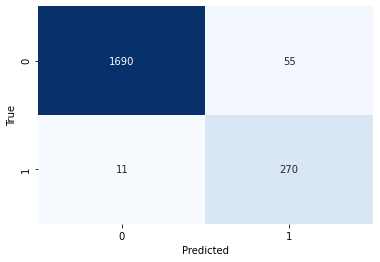

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1745
           1       0.83      0.96      0.89       281

    accuracy                           0.97      2026
   macro avg       0.91      0.96      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Logistic Classifier


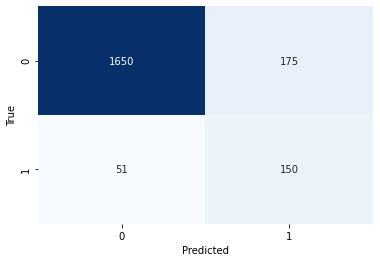

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1825
           1       0.46      0.75      0.57       201

    accuracy                           0.89      2026
   macro avg       0.72      0.83      0.75      2026
weighted avg       0.92      0.89      0.90      2026



In [30]:
show_metrics(clfers,x_test,y_test)       

In [31]:
df_scores

,F1,Precision,Recall
Models,,,
XGB SMOTE,0.891089,0.830769,0.960854
Random Forest w/o SMOTE,0.822719,0.735385,0.933594
LGB SMOTE,0.891089,0.830769,0.960854
Logistic Classifier,0.570342,0.461538,0.746269


## Optuna (Hyperparamter Search)

In [51]:
import optuna

In [54]:
from sklearn.metrics import log_loss
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    n_estimators = trial.suggest_int('n_estimators', 100, 1500)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    model = RandomForestClassifier(n_estimators =n_estimators, max_depth = max_depth, max_features=max_features,criterion =criterion)
    
    cross_val = cross_val_score(model, x_SM, y_SM, n_jobs=-1, cv=3,scoring= 'neg_log_loss')
    score = cross_val.mean()
    return score

In [55]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=600)

[I 2021-10-25 21:53:55,833] A new study created in memory with name: no-name-3682088f-2b89-4267-9522-c972db253271
[I 2021-10-25 21:54:04,084] Trial 0 finished with value: -0.2688357719255417 and parameters: {'criterion': 'gini', 'n_estimators': 1090, 'max_depth': 6, 'max_features': 'auto'}. Best is trial 0 with value: -0.2688357719255417.
[I 2021-10-25 21:54:15,058] Trial 1 finished with value: -0.15296652412212083 and parameters: {'criterion': 'entropy', 'n_estimators': 942, 'max_depth': 11, 'max_features': 'auto'}. Best is trial 0 with value: -0.2688357719255417.
[I 2021-10-25 21:54:20,528] Trial 2 finished with value: -0.30776003699097637 and parameters: {'criterion': 'entropy', 'n_estimators': 856, 'max_depth': 5, 'max_features': 'auto'}. Best is trial 2 with value: -0.30776003699097637.
[I 2021-10-25 21:54:23,035] Trial 3 finished with value: -0.14570979382555346 and parameters: {'criterion': 'gini', 'n_estimators': 277, 'max_depth': 12, 'max_features': 'auto'}. Best is trial 2 wi

KeyboardInterrupt: 

In [ ]:
print(study.best_params)

In [32]:
import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(x_SM, label=y_SM)
best_params, tuning_history = dict(), list()
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "device_type": "gpu",
       
    }

tuner = lgb.LightGBMTunerCV(
        params, dtrain, verbose_eval=100, early_stopping_rounds=25, folds=KFold(n_splits=4),time_budget=600
        )
    

tuner.run()

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-10-20 14:49:10,282] A new study created in memory with name: no-name-6d107f4b-5106-4c33-83b8-07badc6a4beb
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0553105 + 0.0216088
[200]	cv_agg's binary_logloss: 0.0457385 + 0.0242968


feature_fraction, val_score: 0.045549:  14%|#4        | 1/7 [00:09<00:59,  9.99s/it]

[100]	cv_agg's binary_logloss: 0.0557823 + 0.0210689
[200]	cv_agg's binary_logloss: 0.045901 + 0.0238319


feature_fraction, val_score: 0.045549:  29%|##8       | 2/7 [00:15<00:43,  8.66s/it]

[100]	cv_agg's binary_logloss: 0.0569838 + 0.0198084
[200]	cv_agg's binary_logloss: 0.04524 + 0.0238697


feature_fraction, val_score: 0.044510:  43%|####2     | 3/7 [00:22<00:32,  8.23s/it]

[100]	cv_agg's binary_logloss: 0.0550577 + 0.0201612
[200]	cv_agg's binary_logloss: 0.0454882 + 0.0237002


feature_fraction, val_score: 0.044510:  57%|#####7    | 4/7 [00:28<00:22,  7.56s/it]

[100]	cv_agg's binary_logloss: 0.064639 + 0.0188365
[200]	cv_agg's binary_logloss: 0.0462967 + 0.0217485
[300]	cv_agg's binary_logloss: 0.0442567 + 0.0239143


feature_fraction, val_score: 0.044027:  71%|#######1  | 5/7 [00:36<00:14,  7.47s/it]

[100]	cv_agg's binary_logloss: 0.0587781 + 0.0183761
[200]	cv_agg's binary_logloss: 0.0450421 + 0.0216342


feature_fraction, val_score: 0.043895:  86%|########5 | 6/7 [00:43<00:07,  7.34s/it]

[100]	cv_agg's binary_logloss: 0.0549097 + 0.019875
[200]	cv_agg's binary_logloss: 0.0449953 + 0.0230635


num_leaves, val_score: 0.043895:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0511896 + 0.0204287


num_leaves, val_score: 0.043895:   5%|5         | 1/20 [00:08<02:35,  8.17s/it]

[100]	cv_agg's binary_logloss: 0.0504197 + 0.0197528
[200]	cv_agg's binary_logloss: 0.045737 + 0.0249593


num_leaves, val_score: 0.043895:  10%|#         | 2/20 [00:17<02:32,  8.45s/it]

[100]	cv_agg's binary_logloss: 0.046868 + 0.0208976


num_leaves, val_score: 0.043895:  15%|#5        | 3/20 [00:34<03:08, 11.09s/it]

[100]	cv_agg's binary_logloss: 0.0471571 + 0.0205228


num_leaves, val_score: 0.043895:  20%|##        | 4/20 [00:49<03:18, 12.40s/it]

[100]	cv_agg's binary_logloss: 0.0479466 + 0.0207435


num_leaves, val_score: 0.043895:  25%|##5       | 5/20 [01:00<02:58, 11.89s/it]

[100]	cv_agg's binary_logloss: 0.0471064 + 0.0214303


num_leaves, val_score: 0.043895:  30%|###       | 6/20 [01:18<03:09, 13.56s/it]

[100]	cv_agg's binary_logloss: 0.0835424 + 0.018392
[200]	cv_agg's binary_logloss: 0.0578414 + 0.019615
[300]	cv_agg's binary_logloss: 0.0503868 + 0.0201026
[400]	cv_agg's binary_logloss: 0.0473059 + 0.0221528
[500]	cv_agg's binary_logloss: 0.0458596 + 0.0234535


num_leaves, val_score: 0.043895:  35%|###5      | 7/20 [01:23<02:24, 11.15s/it]

[100]	cv_agg's binary_logloss: 0.0476272 + 0.0220239


num_leaves, val_score: 0.043895:  40%|####      | 8/20 [01:42<02:41, 13.46s/it]

[100]	cv_agg's binary_logloss: 0.051229 + 0.0199747
[200]	cv_agg's binary_logloss: 0.0446845 + 0.023769


num_leaves, val_score: 0.043895:  45%|####5     | 9/20 [01:51<02:13, 12.11s/it]

[100]	cv_agg's binary_logloss: 0.048007 + 0.0208537


num_leaves, val_score: 0.043895:  50%|#####     | 10/20 [02:11<02:25, 14.59s/it]

[100]	cv_agg's binary_logloss: 0.0455678 + 0.0200459


num_leaves, val_score: 0.043895:  55%|#####5    | 11/20 [02:35<02:35, 17.26s/it]

[100]	cv_agg's binary_logloss: 0.0474121 + 0.0212525


num_leaves, val_score: 0.043895:  60%|######    | 12/20 [03:00<02:35, 19.49s/it]

[100]	cv_agg's binary_logloss: 0.124586 + 0.0194691
[200]	cv_agg's binary_logloss: 0.0828927 + 0.0191886
[300]	cv_agg's binary_logloss: 0.0690672 + 0.020311
[400]	cv_agg's binary_logloss: 0.0617414 + 0.0203767
[500]	cv_agg's binary_logloss: 0.0569603 + 0.0208134
[600]	cv_agg's binary_logloss: 0.053514 + 0.0215471
[700]	cv_agg's binary_logloss: 0.0512891 + 0.0222607
[800]	cv_agg's binary_logloss: 0.0499488 + 0.0234359


num_leaves, val_score: 0.043895:  65%|######5   | 13/20 [03:04<01:45, 15.08s/it]

[100]	cv_agg's binary_logloss: 0.0481013 + 0.0210686


num_leaves, val_score: 0.043895:  70%|#######   | 14/20 [03:18<01:27, 14.62s/it]

[100]	cv_agg's binary_logloss: 0.0470754 + 0.0208067


num_leaves, val_score: 0.043895:  75%|#######5  | 15/20 [03:41<01:25, 17.20s/it]

[100]	cv_agg's binary_logloss: 0.0532983 + 0.0199881
[200]	cv_agg's binary_logloss: 0.0443133 + 0.0235948


num_leaves, val_score: 0.043895:  80%|########  | 16/20 [03:50<00:58, 14.66s/it]

[100]	cv_agg's binary_logloss: 0.0528874 + 0.0196765
[200]	cv_agg's binary_logloss: 0.0455181 + 0.0232181


num_leaves, val_score: 0.043895:  85%|########5 | 17/20 [03:58<00:38, 12.67s/it]

[100]	cv_agg's binary_logloss: 0.0584676 + 0.0197426
[200]	cv_agg's binary_logloss: 0.0452008 + 0.0225494


num_leaves, val_score: 0.043895:  90%|######### | 18/20 [04:05<00:22, 11.10s/it]

[100]	cv_agg's binary_logloss: 0.0487529 + 0.0218487


num_leaves, val_score: 0.043895:  95%|#########5| 19/20 [04:16<00:10, 10.97s/it]

[100]	cv_agg's binary_logloss: 0.0600322 + 0.0185593
[200]	cv_agg's binary_logloss: 0.0454055 + 0.0213857
[300]	cv_agg's binary_logloss: 0.043942 + 0.0246527


bagging, val_score: 0.043793:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0624894 + 0.0200715
[200]	cv_agg's binary_logloss: 0.0475215 + 0.0231739
[300]	cv_agg's binary_logloss: 0.0461853 + 0.0259107


bagging, val_score: 0.043793:  10%|#         | 1/10 [00:09<01:28,  9.84s/it]

[100]	cv_agg's binary_logloss: 0.0618748 + 0.020239
[200]	cv_agg's binary_logloss: 0.0486241 + 0.0234215


bagging, val_score: 0.043793:  20%|##        | 2/10 [00:18<01:15,  9.46s/it]

[100]	cv_agg's binary_logloss: 0.0590355 + 0.0190742
[200]	cv_agg's binary_logloss: 0.0444755 + 0.0219212
[300]	cv_agg's binary_logloss: 0.0435151 + 0.0248947


bagging, val_score: 0.043170:  30%|###       | 3/10 [00:27<01:04,  9.21s/it]

[100]	cv_agg's binary_logloss: 0.0601469 + 0.0193496
[200]	cv_agg's binary_logloss: 0.0462227 + 0.0225244


bagging, val_score: 0.043170:  40%|####      | 4/10 [00:33<00:51,  8.51s/it]

[300]	cv_agg's binary_logloss: 0.0446297 + 0.0243224
[100]	cv_agg's binary_logloss: 0.0604795 + 0.0186482
[200]	cv_agg's binary_logloss: 0.0466302 + 0.0222518
[300]	cv_agg's binary_logloss: 0.0445538 + 0.0247233


bagging, val_score: 0.043170:  50%|#####     | 5/10 [00:42<00:42,  8.54s/it]

[100]	cv_agg's binary_logloss: 0.0596361 + 0.0195516
[200]	cv_agg's binary_logloss: 0.0448876 + 0.0211313
[300]	cv_agg's binary_logloss: 0.0426143 + 0.0237701


bagging, val_score: 0.042394:  60%|######    | 6/10 [00:51<00:35,  8.82s/it]

[100]	cv_agg's binary_logloss: 0.0635493 + 0.0203712
[200]	cv_agg's binary_logloss: 0.0498558 + 0.0229506
[300]	cv_agg's binary_logloss: 0.047424 + 0.0240931


bagging, val_score: 0.042394:  70%|#######   | 7/10 [01:01<00:27,  9.06s/it]

[100]	cv_agg's binary_logloss: 0.0600838 + 0.0182927
[200]	cv_agg's binary_logloss: 0.0465327 + 0.0217496
[300]	cv_agg's binary_logloss: 0.0448043 + 0.0238095


bagging, val_score: 0.042394:  80%|########  | 8/10 [01:11<00:18,  9.33s/it]

[100]	cv_agg's binary_logloss: 0.0599626 + 0.0188269
[200]	cv_agg's binary_logloss: 0.0454427 + 0.0214032
[300]	cv_agg's binary_logloss: 0.0429406 + 0.0229472


bagging, val_score: 0.042394:  90%|######### | 9/10 [01:20<00:09,  9.07s/it]

[100]	cv_agg's binary_logloss: 0.0608648 + 0.0205674
[200]	cv_agg's binary_logloss: 0.0459521 + 0.0229574


feature_fraction_stage2, val_score: 0.042394:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0635416 + 0.0188214
[200]	cv_agg's binary_logloss: 0.0467307 + 0.0209357
[300]	cv_agg's binary_logloss: 0.0435402 + 0.0231134


feature_fraction_stage2, val_score: 0.042394:  17%|#6        | 1/6 [00:09<00:45,  9.16s/it]

[100]	cv_agg's binary_logloss: 0.0583492 + 0.0193686
[200]	cv_agg's binary_logloss: 0.0450514 + 0.0228568


feature_fraction_stage2, val_score: 0.042394:  33%|###3      | 2/6 [00:17<00:35,  8.83s/it]

[100]	cv_agg's binary_logloss: 0.0591019 + 0.0198621
[200]	cv_agg's binary_logloss: 0.0444982 + 0.0221929


feature_fraction_stage2, val_score: 0.042394:  50%|#####     | 3/6 [00:26<00:26,  8.84s/it]

[300]	cv_agg's binary_logloss: 0.0431796 + 0.0241835
[100]	cv_agg's binary_logloss: 0.059497 + 0.0199942
[200]	cv_agg's binary_logloss: 0.0455152 + 0.0219173


feature_fraction_stage2, val_score: 0.042394:  67%|######6   | 4/6 [00:34<00:17,  8.76s/it]

[100]	cv_agg's binary_logloss: 0.0620978 + 0.0193546
[200]	cv_agg's binary_logloss: 0.0452318 + 0.0222682


feature_fraction_stage2, val_score: 0.042394:  83%|########3 | 5/6 [00:43<00:08,  8.69s/it]

[100]	cv_agg's binary_logloss: 0.0626538 + 0.0196237
[200]	cv_agg's binary_logloss: 0.0460936 + 0.0204673


regularization_factors, val_score: 0.042394:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0612338 + 0.0193488
[200]	cv_agg's binary_logloss: 0.0463112 + 0.021561
[300]	cv_agg's binary_logloss: 0.0440412 + 0.0231892


regularization_factors, val_score: 0.042394:   5%|5         | 1/20 [00:09<03:05,  9.74s/it]

[100]	cv_agg's binary_logloss: 0.0737879 + 0.0196632
[200]	cv_agg's binary_logloss: 0.0547686 + 0.0206432
[300]	cv_agg's binary_logloss: 0.0493874 + 0.0212814
[400]	cv_agg's binary_logloss: 0.0470481 + 0.0217468
[500]	cv_agg's binary_logloss: 0.046018 + 0.0224013
[600]	cv_agg's binary_logloss: 0.0452102 + 0.0227787


regularization_factors, val_score: 0.042394:  10%|#         | 2/20 [00:29<03:51, 12.85s/it]

[100]	cv_agg's binary_logloss: 0.0598769 + 0.019133
[200]	cv_agg's binary_logloss: 0.0457431 + 0.021295
[300]	cv_agg's binary_logloss: 0.0444437 + 0.023732


regularization_factors, val_score: 0.042394:  15%|#5        | 3/20 [00:39<03:22, 11.90s/it]

[100]	cv_agg's binary_logloss: 0.0589623 + 0.0196683
[200]	cv_agg's binary_logloss: 0.0449257 + 0.0216288


regularization_factors, val_score: 0.042394:  20%|##        | 4/20 [00:49<03:02, 11.38s/it]

[100]	cv_agg's binary_logloss: 0.0602374 + 0.0202634
[200]	cv_agg's binary_logloss: 0.0454284 + 0.0219415


regularization_factors, val_score: 0.042394:  25%|##5       | 5/20 [00:58<02:39, 10.63s/it]

[300]	cv_agg's binary_logloss: 0.0440935 + 0.0250292
[100]	cv_agg's binary_logloss: 0.0604543 + 0.0195968
[200]	cv_agg's binary_logloss: 0.0454754 + 0.0214215
[300]	cv_agg's binary_logloss: 0.0437187 + 0.0234886


regularization_factors, val_score: 0.042394:  30%|###       | 6/20 [01:08<02:24, 10.34s/it]

[100]	cv_agg's binary_logloss: 0.0594501 + 0.0189521
[200]	cv_agg's binary_logloss: 0.0456663 + 0.0215201


regularization_factors, val_score: 0.042394:  35%|###5      | 7/20 [01:17<02:08,  9.89s/it]

[300]	cv_agg's binary_logloss: 0.0438856 + 0.0232983
[100]	cv_agg's binary_logloss: 0.0596763 + 0.0195411
[200]	cv_agg's binary_logloss: 0.0453925 + 0.0216882
[300]	cv_agg's binary_logloss: 0.0438079 + 0.0237147


regularization_factors, val_score: 0.042394:  40%|####      | 8/20 [01:26<01:57,  9.80s/it]

[100]	cv_agg's binary_logloss: 0.0587915 + 0.0185556
[200]	cv_agg's binary_logloss: 0.0442252 + 0.020152
[300]	cv_agg's binary_logloss: 0.0431013 + 0.0224358


regularization_factors, val_score: 0.042394:  45%|####5     | 9/20 [01:35<01:46,  9.64s/it]

[100]	cv_agg's binary_logloss: 0.0593934 + 0.0196343
[200]	cv_agg's binary_logloss: 0.0457219 + 0.0224686


regularization_factors, val_score: 0.042394:  50%|#####     | 10/20 [01:44<01:33,  9.39s/it]

[100]	cv_agg's binary_logloss: 0.0872107 + 0.019674
[200]	cv_agg's binary_logloss: 0.0711097 + 0.019946


regularization_factors, val_score: 0.042394:  55%|#####5    | 11/20 [01:51<01:16,  8.47s/it]

[100]	cv_agg's binary_logloss: 0.0592618 + 0.0189994
[200]	cv_agg's binary_logloss: 0.0451247 + 0.021519


regularization_factors, val_score: 0.042394:  60%|######    | 12/20 [01:59<01:07,  8.45s/it]

[100]	cv_agg's binary_logloss: 0.0587205 + 0.0191529
[200]	cv_agg's binary_logloss: 0.0443349 + 0.021224
[300]	cv_agg's binary_logloss: 0.043033 + 0.0236853


regularization_factors, val_score: 0.042394:  65%|######5   | 13/20 [02:09<01:02,  8.98s/it]

[100]	cv_agg's binary_logloss: 0.059317 + 0.0201378
[200]	cv_agg's binary_logloss: 0.0454481 + 0.0225141


regularization_factors, val_score: 0.042394:  70%|#######   | 14/20 [02:18<00:53,  8.96s/it]

[100]	cv_agg's binary_logloss: 0.0597403 + 0.020047
[200]	cv_agg's binary_logloss: 0.0456334 + 0.0222395


  0%|          | 0/5 [00:00<?, ?it/s]

[300]	cv_agg's binary_logloss: 0.0443638 + 0.0249998
Best score: 0.04239368928765934
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 28, 'feature_fraction': 0.5, 'bagging_fraction': 0.768023517992883, 'bagging_freq': 5, 'min_child_samples': 20}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    device_type: gpu
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 28
    feature_fraction: 0.5
    bagging_fraction: 0.768023517992883
    bagging_freq: 5
    min_child_samples: 20


In [33]:
print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.04239368928765934
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 28, 'feature_fraction': 0.5, 'bagging_fraction': 0.768023517992883, 'bagging_freq': 5, 'min_child_samples': 20}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    device_type: gpu
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 28
    feature_fraction: 0.5
    bagging_fraction: 0.768023517992883
    bagging_freq: 5
    min_child_samples: 20


In [39]:
def objective(trial):
    dtrain = xgb.DMatrix(x_SM, label=y_SM)
    param = {
        'tree_method' : "gpu_hist",
        'single_precision_histogram' :True,
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        # use exact for small dataset.
        "tree_method": "exact",
        # Dart booster is utilzing dropouts
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "learning_rate" :trial.suggest_loguniform('learning_rate', .005, .05),
        #"n_estimators" : trial.suggest_int('n_estimators', 100, 1500),
        "max_depth" : trial.suggest_int('max_depth', 2, 20),
        "gamma" : trial.suggest_loguniform("gamma", 1e-8, 5.0),
        "min_child_weight" :  trial.suggest_loguniform("min_child_weight", .1, 10.),
    }
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(param, dtrain, num_boost_round=2000,
                     early_stopping_rounds=50,shuffle=True,seed=1, callbacks=[pruning_callback])
    log_loss = history["test-logloss-mean"].values[-1]
    return log_loss

In [42]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-10-20 15:06:20,691] A new study created in memory with name: no-name-0c486253-e0b0-426e-8f25-e48eb7f4e856
[I 2021-10-20 15:29:23,873] Trial 0 finished with value: 0.047392 and parameters: {'booster': 'dart', 'lambda': 0.011476724492995322, 'alpha': 1.6607275046124928e-06, 'subsample': 0.581427058583839, 'colsample_bytree': 0.8638939024846628, 'learning_rate': 0.014194689335050444, 'max_depth': 18, 'gamma': 0.002500646867019341, 'min_child_weight': 0.30301588482578984, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.295191967554338e-08, 'skip_drop': 0.0009003946010892193}. Best is trial 0 with value: 0.047392.
[I 2021-10-20 15:29:42,493] Trial 1 finished with value: 0.044856 and parameters: {'booster': 'gbtree', 'lambda': 2.3800448570820594e-08, 'alpha': 7.892551478463991e-07, 'subsample': 0.7039214439109296, 'colsample_bytree': 0.32101687768840165, 'learning_rate': 0.011333510556773794, 'max_depth': 7, 'gamma': 0.0011133662222412252, 'min_child_weight': 1.20

In [43]:
print(study.best_params)

{'booster': 'gbtree', 'lambda': 0.8510980791355207, 'alpha': 5.887029350317066e-08, 'subsample': 0.6131070998395973, 'colsample_bytree': 0.6900176269350642, 'learning_rate': 0.04334524528572498, 'max_depth': 8, 'gamma': 4.2724632731185067e-07, 'min_child_weight': 0.18379329253685098}
